# `shapely`对矢量数据的处理(2) 编辑与变换

In [1]:
import shapely; 
import shapely.geometry as shplgeo, shapely.affinity as shplaffin; 
import shapely.ops as shplops; 
import pyproj

In [2]:
#定义三角形ΔABC, 其中∠C是直角
vertex_coord = ((1, 0), (0, 1), (0, 0)); 
A, B, C = tuple(shplgeo.Point(x, y) for x, y in vertex_coord); 
verteces = shplgeo.multipoint.MultiPoint(vertex_coord); 
triangleABC = shplgeo.Polygon(verteces); 
print(triangleABC); 

POLYGON ((1 0, 0 1, 0 0, 1 0))


## 基于`shapely.affinity`的仿射变换

### 特殊的仿射变换
|函数|功能|备注|
|:-|:-:|:-|
|`translate(shp, xoff=Δx., `<br>`yoff=Δy., zoff=Δz.)`|图形沿向量<br>$\left(\Delta x, \Delta y, \Delta z\right)$平移||
|`rotate(shp, θ, origin=coord, `<br>`use_radians=False)`|图形绕xOy平面内<br>坐标为$coord$的点<br>逆时针旋转$\theta$|`origin=coord`缺省时, <br>采用图形几何中心坐标; <br>`use_radians`选项指定<br>$\theta$是否采用弧度制|
|`scale(shp, xfact=λ, yfact=μ, `<br>`zfact=ν, origin='center')`|图形沿$O$$x$, $O$$y$, $O$$z$方向<br>分别缩放至原来的$\lambda$, $\mu$, $\nu$倍, <br>其中坐标为$coord$的点<br>在缩放前后位置保持不变|`origin=coord`缺省时, <br>采用图形几何中心坐标|
|`skew(shp, xs=θ, ys=φ, `<br>`origin='center', `<br>`shpuse_radians=False`|图形沿$O$$x$, $O$$y$方向<br>分别逆时针扭曲$\theta$, $\phi$, <br>其中坐标为$coord$的点<br>在切变前后位置保持不变|`origin=coord`缺省时, <br>采用图形几何中心坐标; <br>`use_radians`选项指定<br>$\theta$是否采用弧度制|

In [3]:
#分别构造ΔABC经过平移, 旋转, 缩放所得的图形
import numpy as np; 
#连续向左平移三次, 每次平移9.5单位
shift = [shplaffin.translate(triangleABC, xoff=x) \
    for x in np.linspace(-0.5, -1.5, 3)]; 
#连续绕原点顺时针旋转三次, 每次旋转36°
rot = [shplaffin.rotate(triangleABC, θ, origin=(0, 0)) \
    for θ in np.linspace(-36, -108, 3)];
#连续绕原点等比例放大三次, 每次放大至sqrt(2)倍
scl = [shplaffin.scale(triangleABC, xfact=k, yfact=k, origin=(0, 0)) \
    for k in np.geomspace(np.sqrt(2), 2 * np.sqrt(2), 3)];

POLYGON ((1 0, 0 1, 0 0, 1 0))
POLYGON ((0.5 0, -0.5 1, -0.5 0, 0.5 0))
POLYGON ((0 0, -1 1, -1 0, 0 0))
POLYGON ((-0.5 0, -1.5 1, -1.5 0, -0.5 0))
POLYGON ((0.8090169943749475 -0.5877852522924731, 0.5877852522924731 0.8090169943749475, 0 0, 0.8090169943749475 -0.5877852522924731))
POLYGON ((0.3090169943749475 -0.9510565162951535, 0.9510565162951535 0.3090169943749475, 0 0, 0.3090169943749475 -0.9510565162951535))
POLYGON ((-0.3090169943749473 -0.9510565162951536, 0.9510565162951536 -0.3090169943749473, 0 0, -0.3090169943749473 -0.9510565162951536))
POLYGON ((1.414213562373095 0, 0 1.414213562373095, 0 0, 1.414213562373095 0))
POLYGON ((2 0, 0 2, 0 0, 2 0))
POLYGON ((2.82842712474619 0, 0 2.82842712474619, 0 0, 2.82842712474619 0))


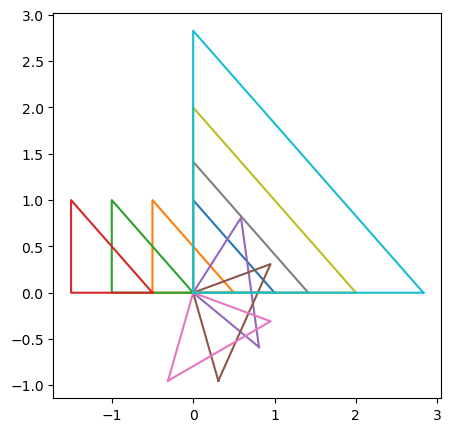

In [4]:
#绘图比较三种变换的效果
import matplotlib.pyplot as plt; 
plt.subplots(figsize=(5, 5)); 
for trans in [triangleABC], shift, rot, scl:
    for polygon in trans: 
        print(polygon); 
        x, y = polygon.boundary.xy; 
        plt.plot(x, y); 
plt.show(); 

### 一般的仿射变换
用法: 
```python
shapely.affinity.affine_transform(shp, matrix_elem)
```
* `matrix_elem` 变换矩阵中的元素
* 适当的变换矩阵可用于表示透视变换, 也可用于前述平移, 旋转, 缩放, 切变变换之间按一定顺序复合形成的合变换; 
* 推荐使用`numpy`中的矩阵运算和线性方程组功能, 计算矩阵中的元素; 

## 地图投影变换
用法: 
```python
shpops.transform(f, shp)
```
* 投影变换不限于线性变换. 
* `f` 表示投影变换的二元函数, 用于将`shp`中每个点的`x`, `y`坐标顺次代入得到投影后的坐标
    * 推荐使用`pyproj`中的投影变换功能构造投影变换解算公式`f`
    * 变换过程中, `f`将通过向量化机制在每个点上顺次执行, 不需要手动编写循环语句
* 返回结果是投影变换后的图形对象, 类型与`shp`相同

In [5]:
#定义微分圆的示意图
diff_Circ = shplgeo.MultiLineString( [\
    C.buffer(1).boundary, 
    shplgeo.LineString([[-1, 0], [1, 0]]),
    shplgeo.LineString([[0, -1], [0, 1]])
] ); 
#构造微分圆阵列, 使得微分圆的圆心位于经纬网的交点上
diff_Circ_Array = shplops.unary_union(tuple(
    shplaffin.scale(
        shplaffin.translate(
            diff_Circ, xoff=x, yoff=y
        ), xfact=1 / np.cos(np.radians(y)), origin=(x, y)
    ) for x in np.linspace(75, 135, 13) for y in np.linspace(15, 55, 9)
) ); 

In [6]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

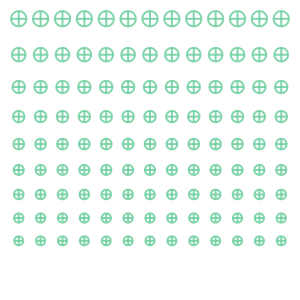

In [7]:
#正轴等角切圆柱投影(Mercator投影)变形特征可视化
#尽可能按照以下语句所示的方法构造投影变换函数, 并施行投影变换, 以提高执行效率
wgs_to_mercator = pyproj.Transformer.from_crs( 
    "EPSG:4326", #WGS 1984 Geodesic
    'epsg:3395', #WGS 1984 / World Mercator
).transform; 
diff_Circ_Array_Mercator = shplops.transform( \
    lambda lon, lat: wgs_to_mercator(lat, lon), 
    shplgeo.MultiLineString(diff_Circ_Array)); 
diff_Circ_Array_Mercator

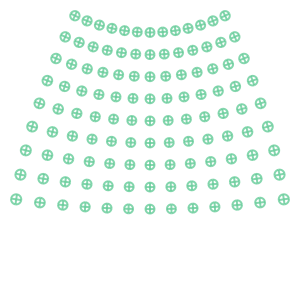

In [8]:
#横轴等角割圆柱投影(通用横轴Mercator, UTM)变形特征可视化
wgs_to_utm648 = pyproj.Transformer.from_crs( 
    "EPSG:4326", #WGS 1984 Geodesic
    'EPSG:32648', #WGS 1984 / UTM 6° Zone 48
).transform; 
diff_Circ_Array_UTM = shplops.transform( \
    lambda lon, lat: wgs_to_utm648(lat, lon), 
    shplgeo.MultiLineString(diff_Circ_Array)); 
diff_Circ_Array_UTM